In [1]:
import tensorflow as tf
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

# Configuring gpu for notebook
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)


python 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
keras version 2.15.0
tensorflow version 2.15.0



In [2]:
# The location of the Flickr8K_ photos
dir_Flickr_jpg = r"C:\Users\aditi\image caption generator\Flickr_Data\Flickr_Data\Images"

# The location of the caption file
dir_Flickr_text = r"C:\Users\aditi\image caption generator\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8089


In [3]:
# read in the Flickr caption data

file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")

# Counting number of captions for each image using counter
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

In [4]:
df_txt[:6]

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   
5  1001773457_577c3a7d70.jpg     0   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  
5         a black dog and a spotted dog are fighting

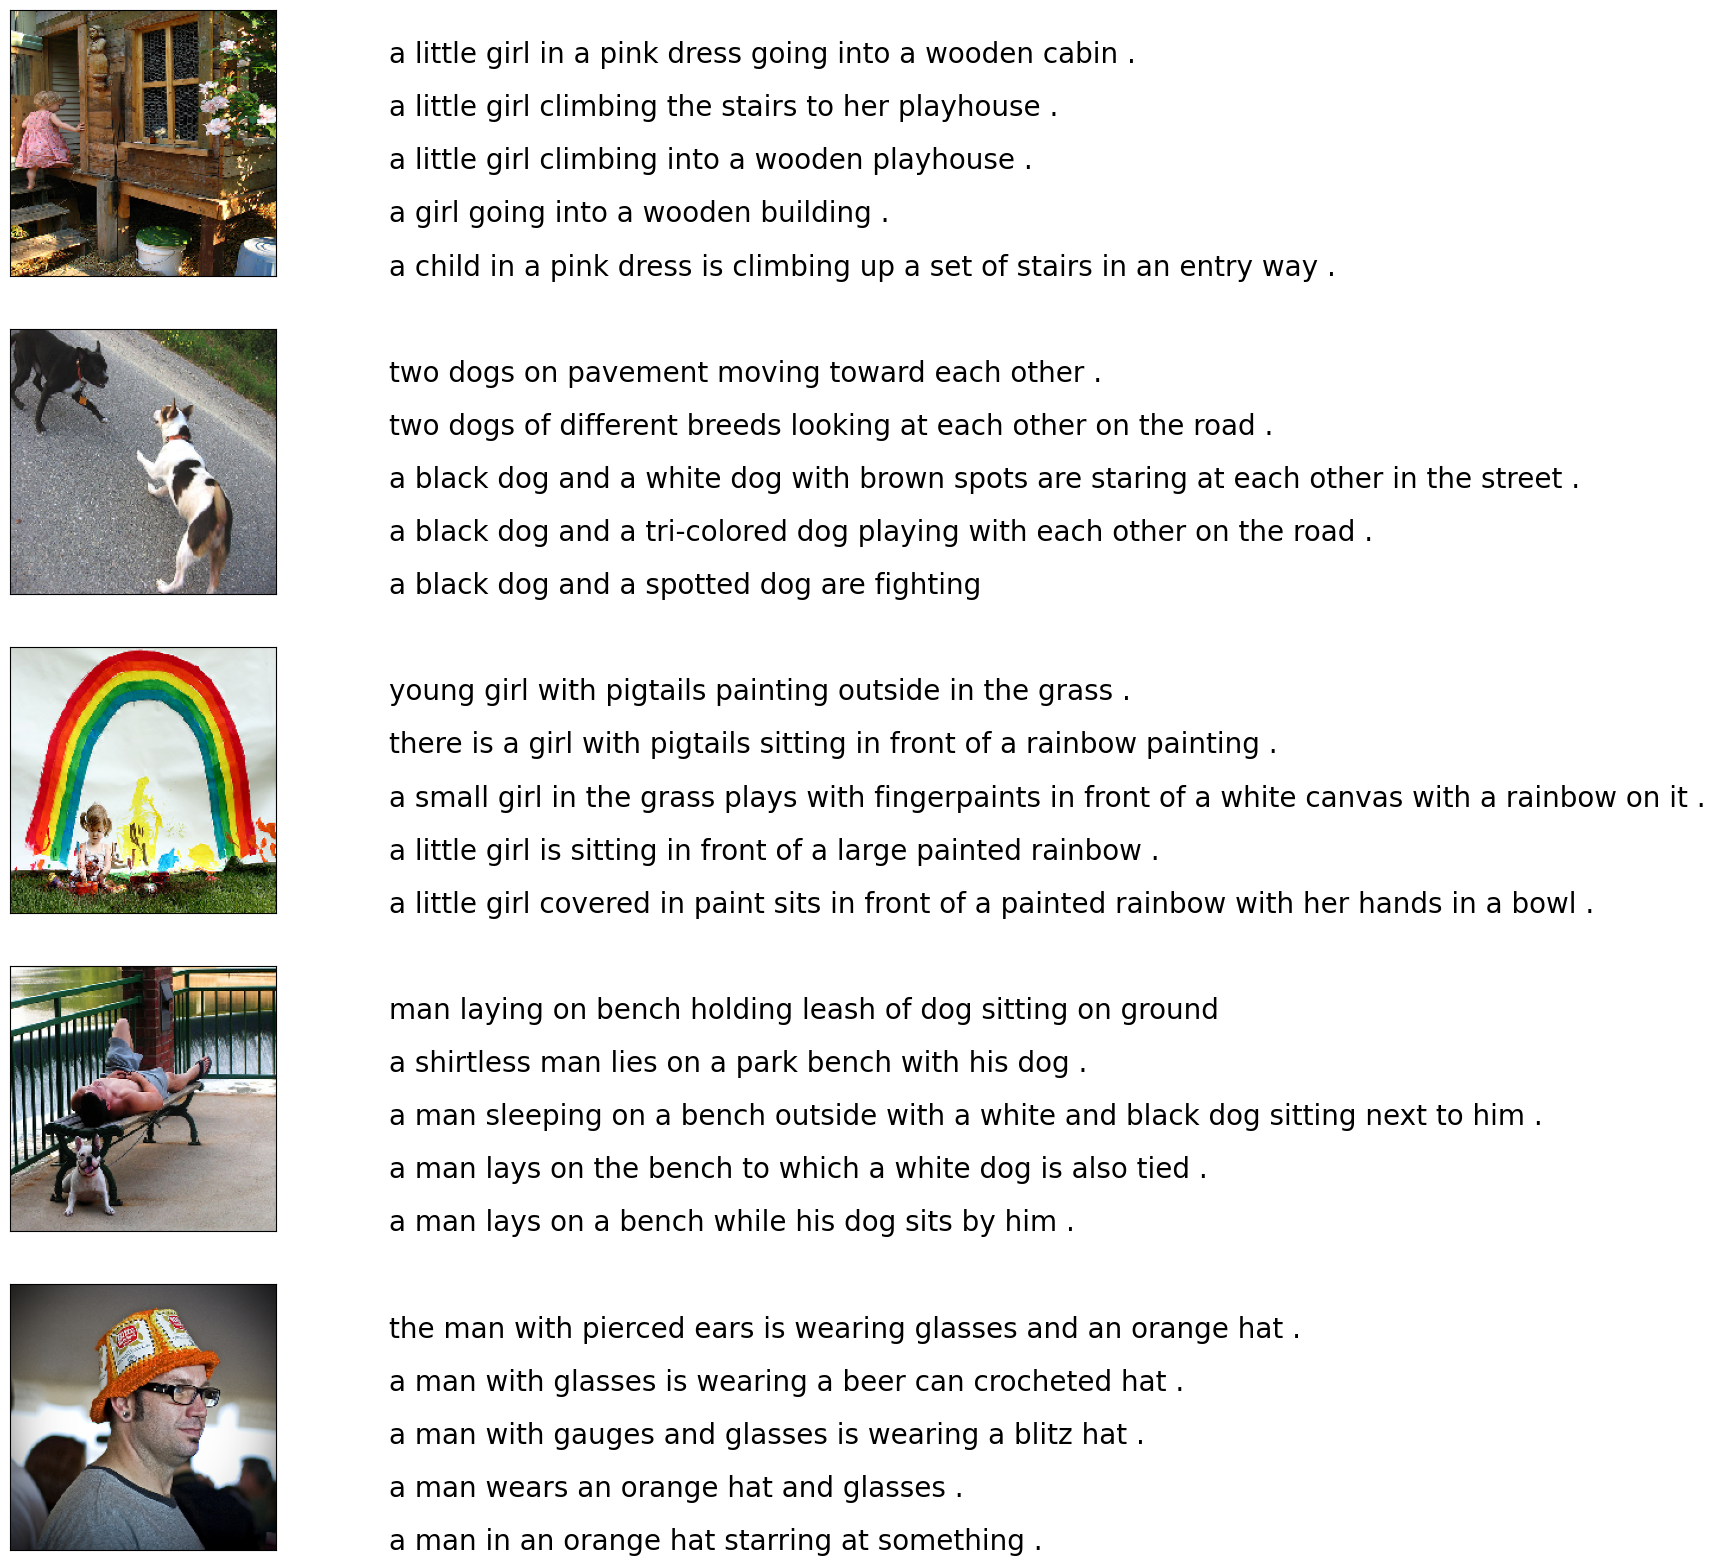

In [5]:
#Example pictures with captions
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Displaying (npic = 5) pics from the dataset
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()


In [6]:
#We create a new dataframe dfword to visualize distribution of the words.
#It contains each word and its frequency in the entire tokens in decreasing order.

def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame(list(ct.items()), columns=['word', 'count'])
    dfword.sort_values(by='count', ascending=False, inplace=True)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975

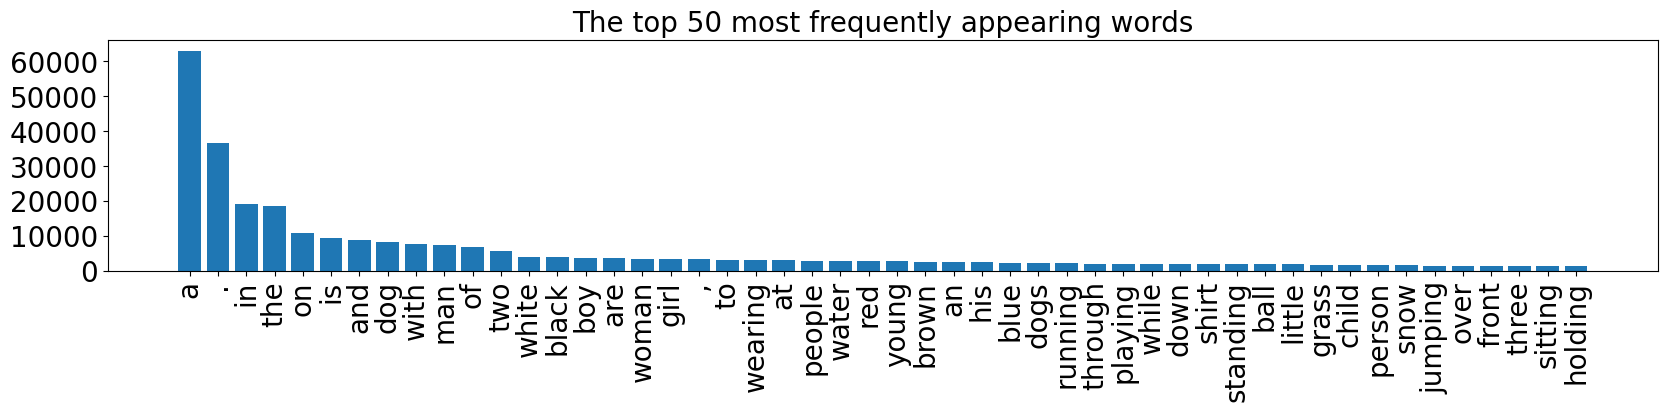

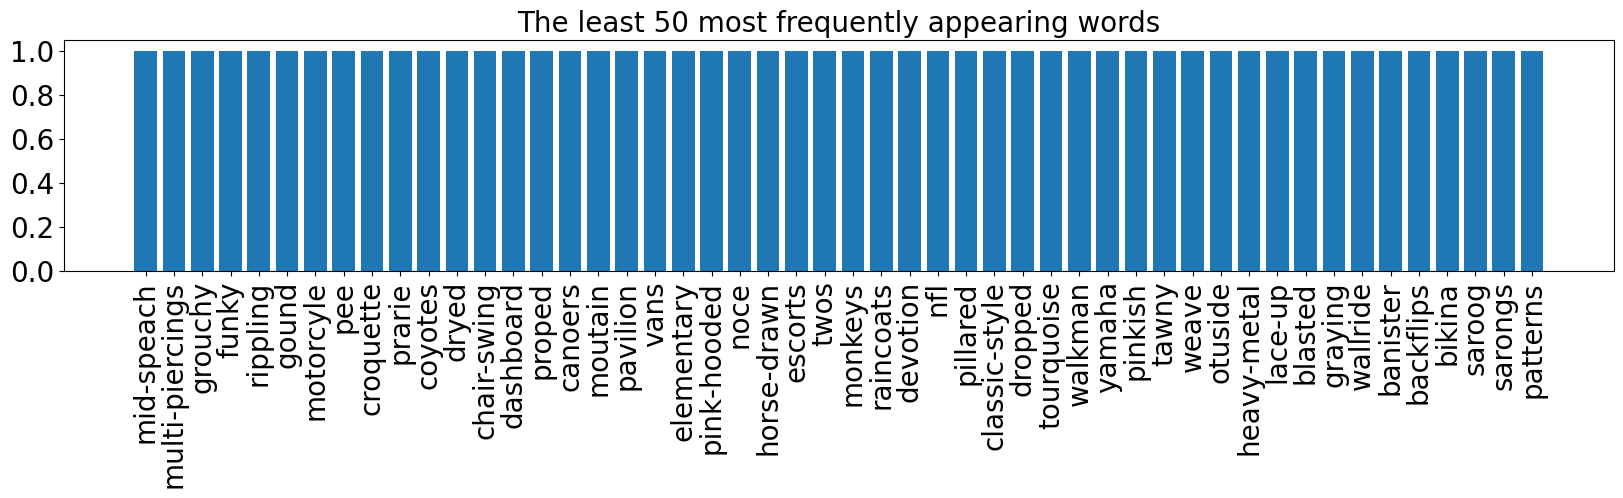

In [7]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [8]:
#In order to clean the caption, We will create three functions that:remove punctuation,
#remove single character, remove numeric characters

import string
text_original = "I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm.Could you give us 20 on 20?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm.Could you give us 20 on 20?

Remove punctuations..
I scored 21 in NLP but Akshat topped I have python v38 Its 420 pmCould you give us 20 on 20

Remove a single character word..
 scored 21 in NLP but Akshat topped have python v38 Its 420 pmCould you give us 20 on 20

Remove words with numeric values..
    scored     : True
    21         : False
    in         : True
    NLP        : True
    but        : True
    Akshat     : True
    topped     : True
    have       : True
    python     : True
    v38        : False
    Its        : True
    420        : False
    pmCould    : True
    you        : True
    give       : True
    us         : True
    20         : False
    on         : True
    20         : False
 scored in NLP but Akshat topped have python Its pmCould you give us on


In [9]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption
    
#After cleaning our vocabulary size is significantly reduced by around 200 words.

Vocabulary Size: 8763


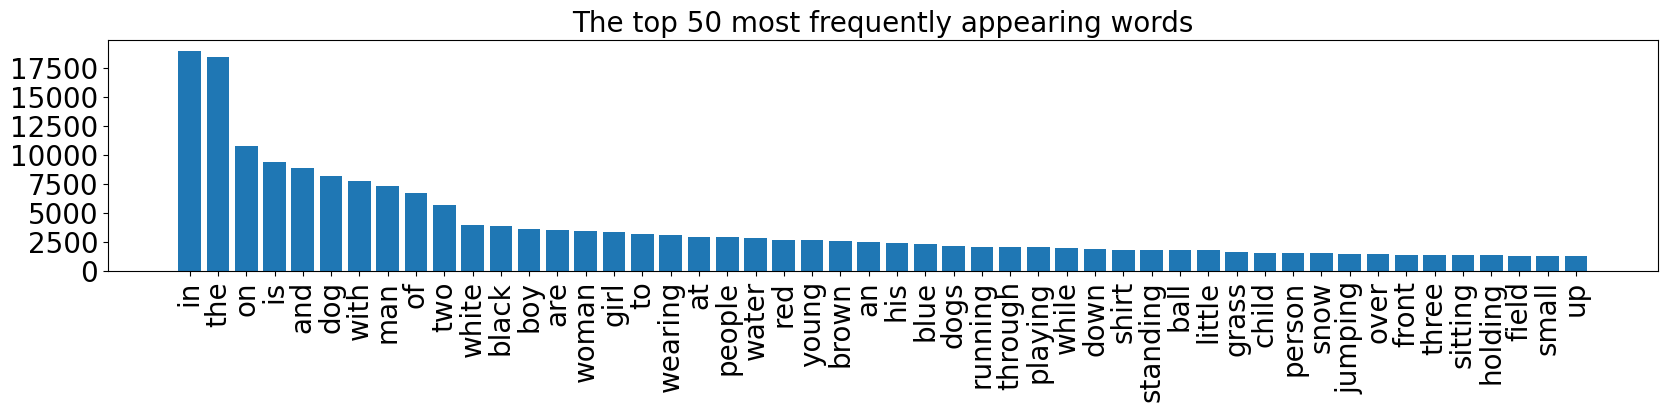

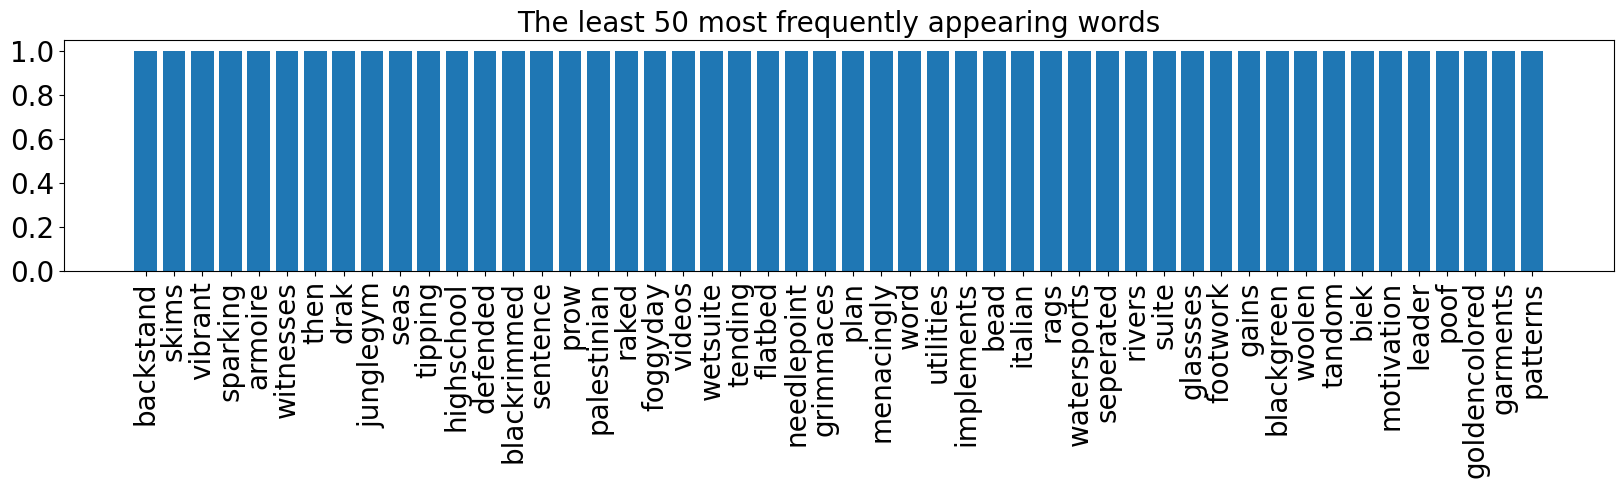

In [10]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [11]:
#Adding Start and End sequence tokens in every caption
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [12]:
#Image Preparation for the VGG16 Model
#We will be using pre-trained network VGG16.This model takes input image of size (224, 224, 3).
#We choose this model because it achieves 92.7% (top-5 test accuracy) in ImageNet

modelvgg = tf.keras.applications.VGG16(include_top=True, weights=None)
# load the locally saved weights 
modelvgg.load_weights(r"C:\Users\aditi\image caption generator\vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [13]:
#VGG16 is developed to classify images into 1,000 different classes. 
# We are not using VGG16 for the classification but we just need it for extracting features
# therefore we will remove the last layer from the network.

modelvgg.layers.pop()
modelvgg = tf.keras.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
# show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
#Transforming images to features using model

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

1/1 [==============================] - 1s 672ms/step


1/1 [==============================] - 0s 472ms/step


1/1 [==============================] - 1s 584ms/step


1/1 [==============================] - 1s 598ms/step


1/1 [==============================] - 1s 753ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 1s 641ms/step


1/1 [==============================] - 1s 641ms/step


1/1 [==============================] - 1s 622ms/step


1/1 [==============================] - 1s 727ms/step


1/1 [==============================] - 1s 526ms/step


1/1 [==============================] - 1s 526ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 1s 788ms/step


1/1 [==============================] - 1s 779ms/step


1/1 [==============================] - 1s 637ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 1s 632ms/step


1/1 [==============================] - 1s 599ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 443ms/step


1/1 [==============================] - 1s 868ms/step


1/1 [==============================] - 1s 628ms/step


1/1 [==============================] - 1s 656ms/step


1/1 [==============================] - 1s 756ms/step


1/1 [==============================] - 1s 707ms/step


1/1 [==============================] - 1s 738ms/step


1/1 [==============================] - 1s 720ms/step


1/1 [==============================] - 1s 662ms/step


1/1 [==============================] - 1s 866ms/step


1/1 [==============================] - 1s 612ms/step


1/1 [==============================] - 1s 598ms/step


1/1 [==============================] - 1s 650ms/step


1/1 [==============================] - 1s 757ms/step


1/1 [==============================] - 1s 647ms/step


1/1 [==============================] - 1s 653ms/step


1/1 [==============================] - 1s 638ms/step


1/1 [==============================] - 1s 693ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 644ms/step


1/1 [==============================] - 1s 660ms/step


1/1 [==============================] - 1s 658ms/step


1/1 [==============================] - 1s 644ms/step


1/1 [==============================] - 1s 679ms/step


1/1 [==============================] - 1s 583ms/step


1/1 [==============================] - 1s 612ms/step


1/1 [==============================] - 1s 745ms/step


1/1 [==============================] - 1s 638ms/step


1/1 [==============================] - 1s 700ms/step


1/1 [==============================] - 1s 705ms/step


1/1 [==============================] - 1s 871ms/step


1/1 [==============================] - 1s 689ms/step


In [15]:
images['1000268201_693b08cb0e.jpg']

array([2.507649, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
      dtype=float32)

In [16]:
#Linking the text and image data
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)


In [17]:
# 4096 features for all 8089 images
dimages.shape

(8089, 4096)

In [18]:
# List of caption for each image
dcaptions[:5]

array(['startseq  child in pink dress is climbing up set of stairs in an entry way endseq',
       'startseq  black dog and spotted dog are fighting endseq',
       'startseq  little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
       'startseq  man lays on bench while his dog sits by him endseq',
       'startseq  man in an orange hat starring at something endseq'],
      dtype=object)

In [19]:
#Tokenizer - Changing character vector to integer vector/tokens
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)


vocabulary size : 4476


In [20]:
# dtexts contains dcaptions but in token/integer form
dtexts[:5]

[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2350, 522, 2],
 [1, 12, 8, 5, 752, 8, 17, 368, 2],
 [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1075, 2],
 [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2],
 [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]

In [21]:
#Spliting the dataset in training and testing
# We will split the dataset in ratio 6:2:2 (train:valid:test)

prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [22]:
# We need maxlen because keras layer takes input of all the sequences of same length.
# Hence to do the padding we need maximum length in caption

maxlen = np.max([len(text) for text in dtexts])

In [23]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1617
 (16345, 30) (16345, 4096) (16345, 4476)


In [24]:
# First caption (dt_train[0]) represented in Xtext_train
Xtext_train[:14]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1, 468],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   1, 468,   7],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1, 468,   7, 299],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
        468,   7, 299, 165],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,

In [25]:
# For each word (49631 words excluding start token) there is a image associated with it
# Image will be same for all words in a caption (i.e. if caption length is 14 Ximage_train[0] = Ximage_train[13])
Ximage_train.shape

(49631, 4096)

In [26]:
# Words one-hot encoding (vocab-size = 4476)
ytext_train.shape

(49631, 4476)

In [27]:
# Model
Ximage_train.shape[1]

4096

In [28]:
from tensorflow.keras import layers
print(vocab_size)
#image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

# sequence model
input_txt = layers.Input(shape=(maxlen,))

# The embedding layer in Keras can be used when we want to create the embeddings to embed higher dimensional data into lower dimensional vector space.
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)

# combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = tf.keras.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 64)               286464    ['input_3[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 CaptionFeature (LSTM)       (None, 256)                  328704    ['embedding[0][0]']           
                                                                                      

In [29]:
# We are giving our model an image and a word (Ximage_train & Xtext_train respectively) 
# and we want it to predict the next word for it which is our target ytext_train
# Example: Here we are giving one image and a start-word and we want to predict next word.
# The next word is in our target which is 75.

print(Ximage_train[0])
print(Xtext_train[0])
print(ytext_train[0][75])

[0.72220623 0.16118994 0.         ... 0.         0.86546993 4.034035  ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
0.0


In [30]:
# fit model
start = time.time()

hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
    
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/5

776/776 - 222s - loss: 5.3357 - val_loss: 4.7865 - 222s/epoch - 286ms/step
Epoch 2/5
776/776 - 212s - loss: 4.3607 - val_loss: 4.4833 - 212s/epoch - 274ms/step
Epoch 3/5
776/776 - 214s - loss: 3.9138 - val_loss: 4.4050 - 214s/epoch - 275ms/step
Epoch 4/5
776/776 - 211s - loss: 3.6074 - val_loss: 4.4352 - 211s/epoch - 272ms/step
Epoch 5/5
776/776 - 211s - loss: 3.3470 - val_loss: 4.5072 - 211s/epoch - 272ms/step
TIME TOOK 17.98MIN


In [31]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(49631, 4096) (49631, 30) (49631, 4476)


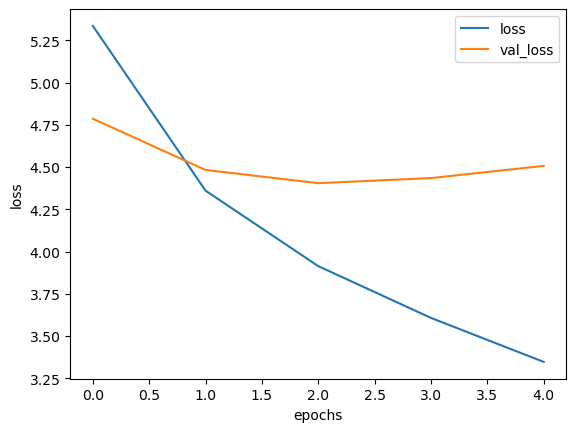

In [32]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

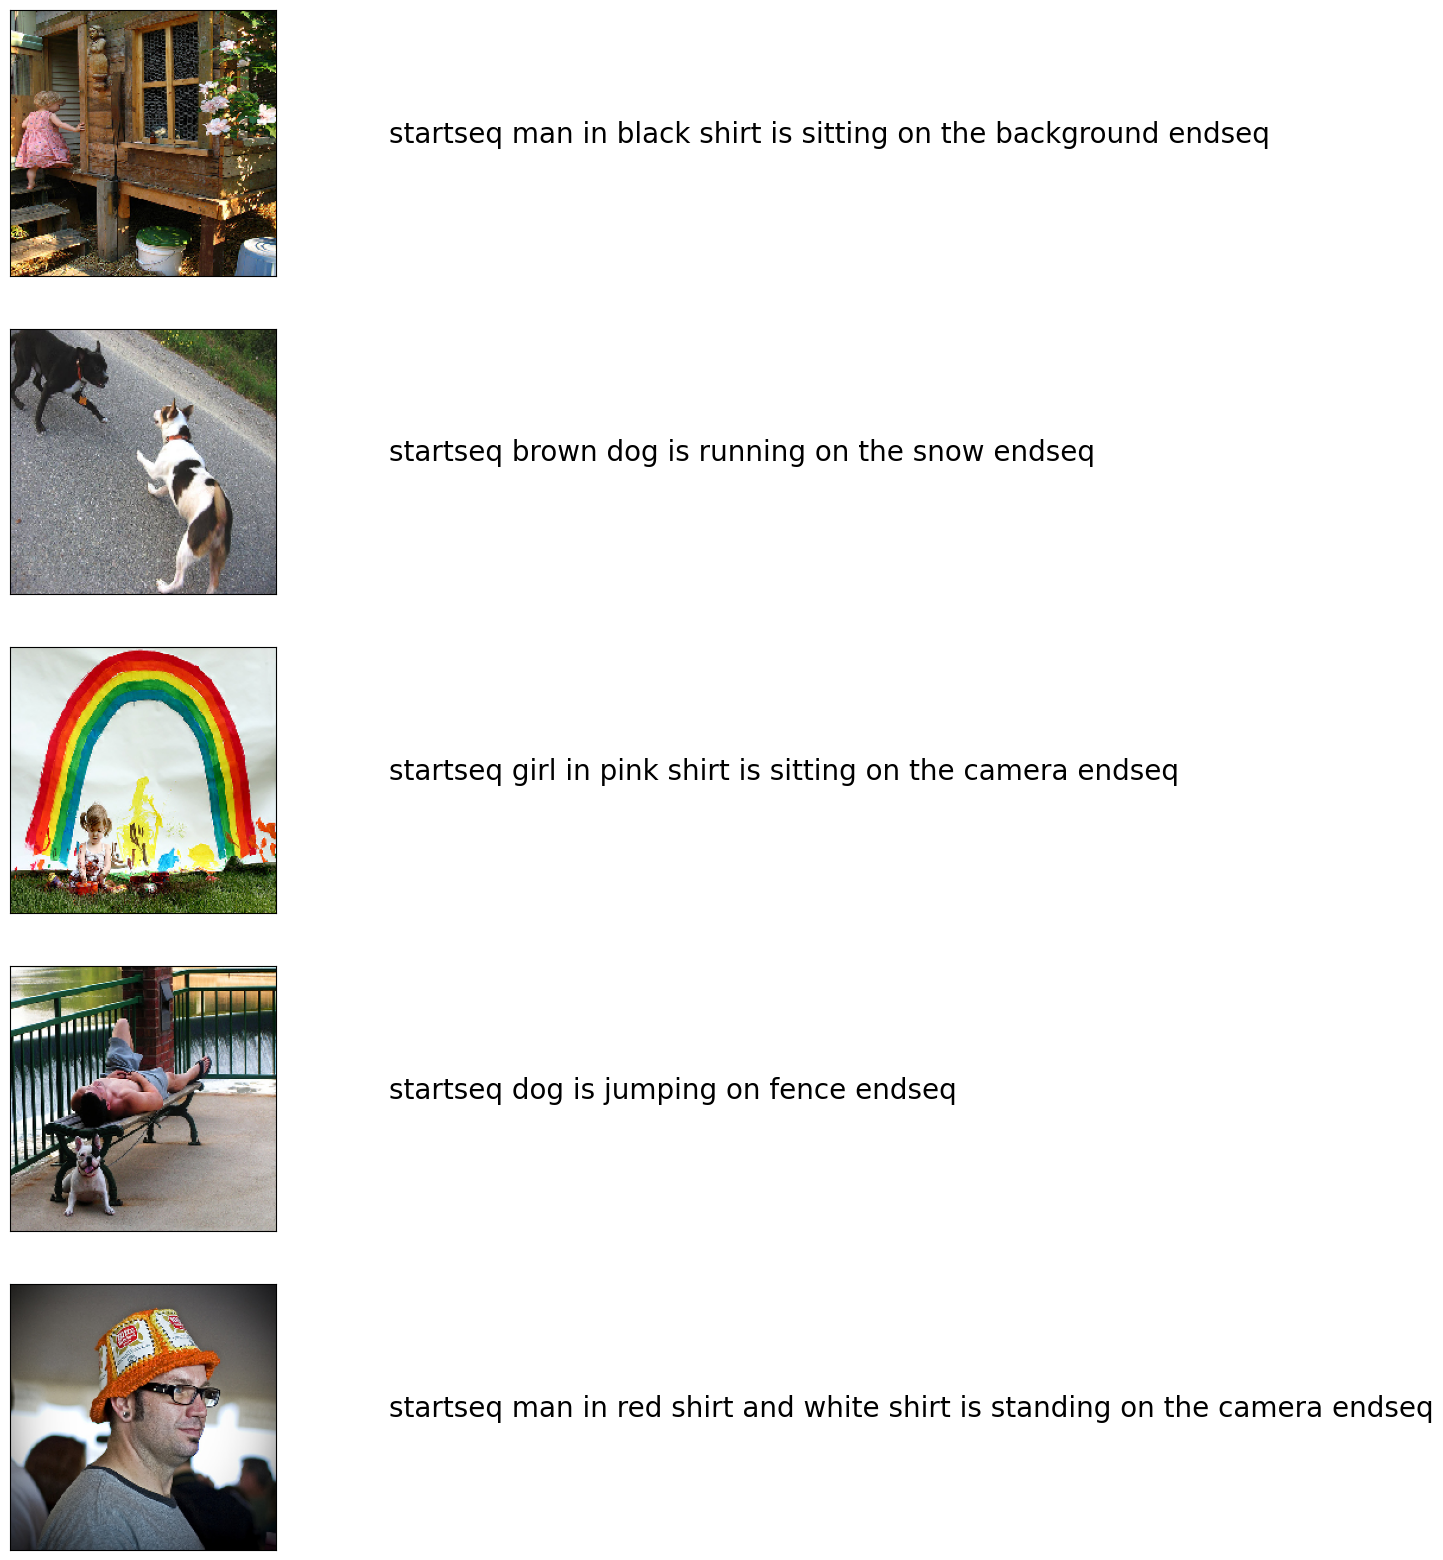

In [33]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [34]:
images['1000268201_693b08cb0e.jpg'].shape

(4096,)

In [35]:
#BLEU SCORE
start = time.time()

from nltk.translate.bleu_score import sentence_bleu

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1] #remove startreg and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.6 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))
        
end = time.time()
print((start-end)/60)

  12.37% is done..
  24.74% is done..
  37.11% is done..
  49.47% is done..
  61.84% is done..
  74.21% is done..
  86.58% is done..
  98.95% is done..
-22.16566050450007


In [36]:
pred_good

[(0.631914561891573,
  '101654506_8eb26cfb60.jpg',
  ['brown', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'snow'],
  ['brown', 'dog', 'is', 'running', 'through', 'the', 'snow']),
 (0.6104735835807844,
  '1119418776_58e4b93eac.jpg',
  ['black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'field'],
  ['black', 'and', 'white', 'dog', 'is', 'running', 'over', 'the', 'grass']),
 (0.6606328636027614,
  '1330645772_24f831ff8f.jpg',
  ['black', 'and', 'white', 'dog', 'is', 'running', 'in', 'the', 'grass'],
  ['black',
   'and',
   'white',
   'dog',
   'is',
   'running',
   'through',
   'the',
   'grass']),
 (0.6147881529512643,
  '1361420539_e9599c60ae.jpg',
  ['black', 'dog', 'is', 'running', 'in', 'the', 'grass'],
  ['black', 'dog', 'is', 'running', 'in', 'its', 'mouth']),
 (0.7259795291154771,
  '1478606153_a7163bf899.jpg',
  ['brown', 'and', 'white', 'dog', 'is', 'running', 'through', 'woodland'],
  ['brown',
   'and',
   'white',
   'dog',
   'is',
   'runn

In [37]:
pred_bad[:2]

[(7.176794039009363e-232,
  '1000268201_693b08cb0e.jpg',
  ['child',
   'in',
   'pink',
   'dress',
   'is',
   'climbing',
   'up',
   'set',
   'of',
   'stairs',
   'in',
   'an',
   'entry',
   'way'],
  ['man', 'in', 'black', 'shirt', 'is', 'sitting', 'on', 'the', 'background']),
 (1.1200407237786664e-231,
  '1001773457_577c3a7d70.jpg',
  ['black', 'dog', 'and', 'spotted', 'dog', 'are', 'fighting'],
  ['brown', 'dog', 'is', 'running', 'on', 'the', 'snow'])]

In [38]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.009


Bad Caption


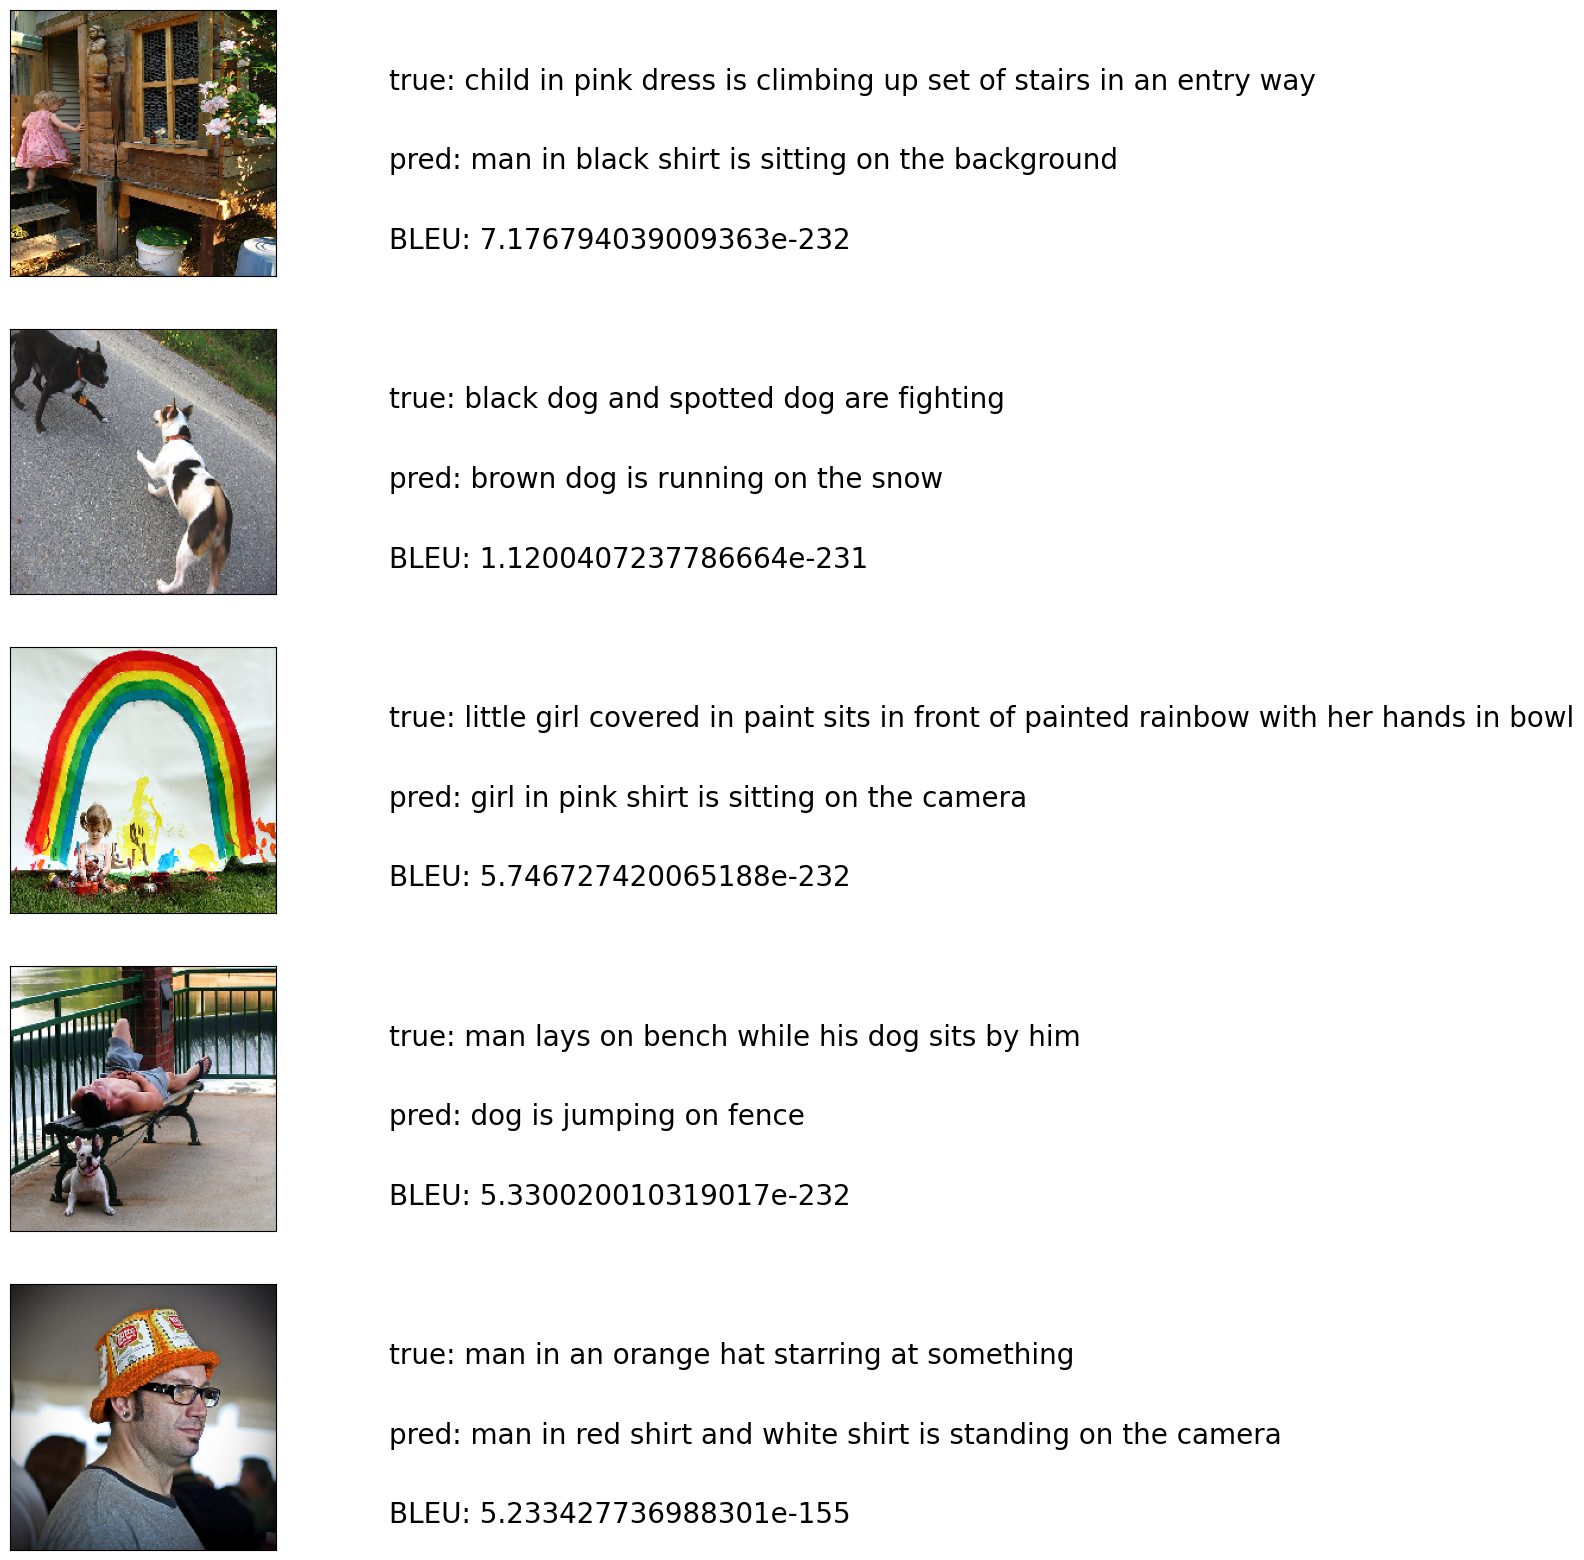

Good Caption


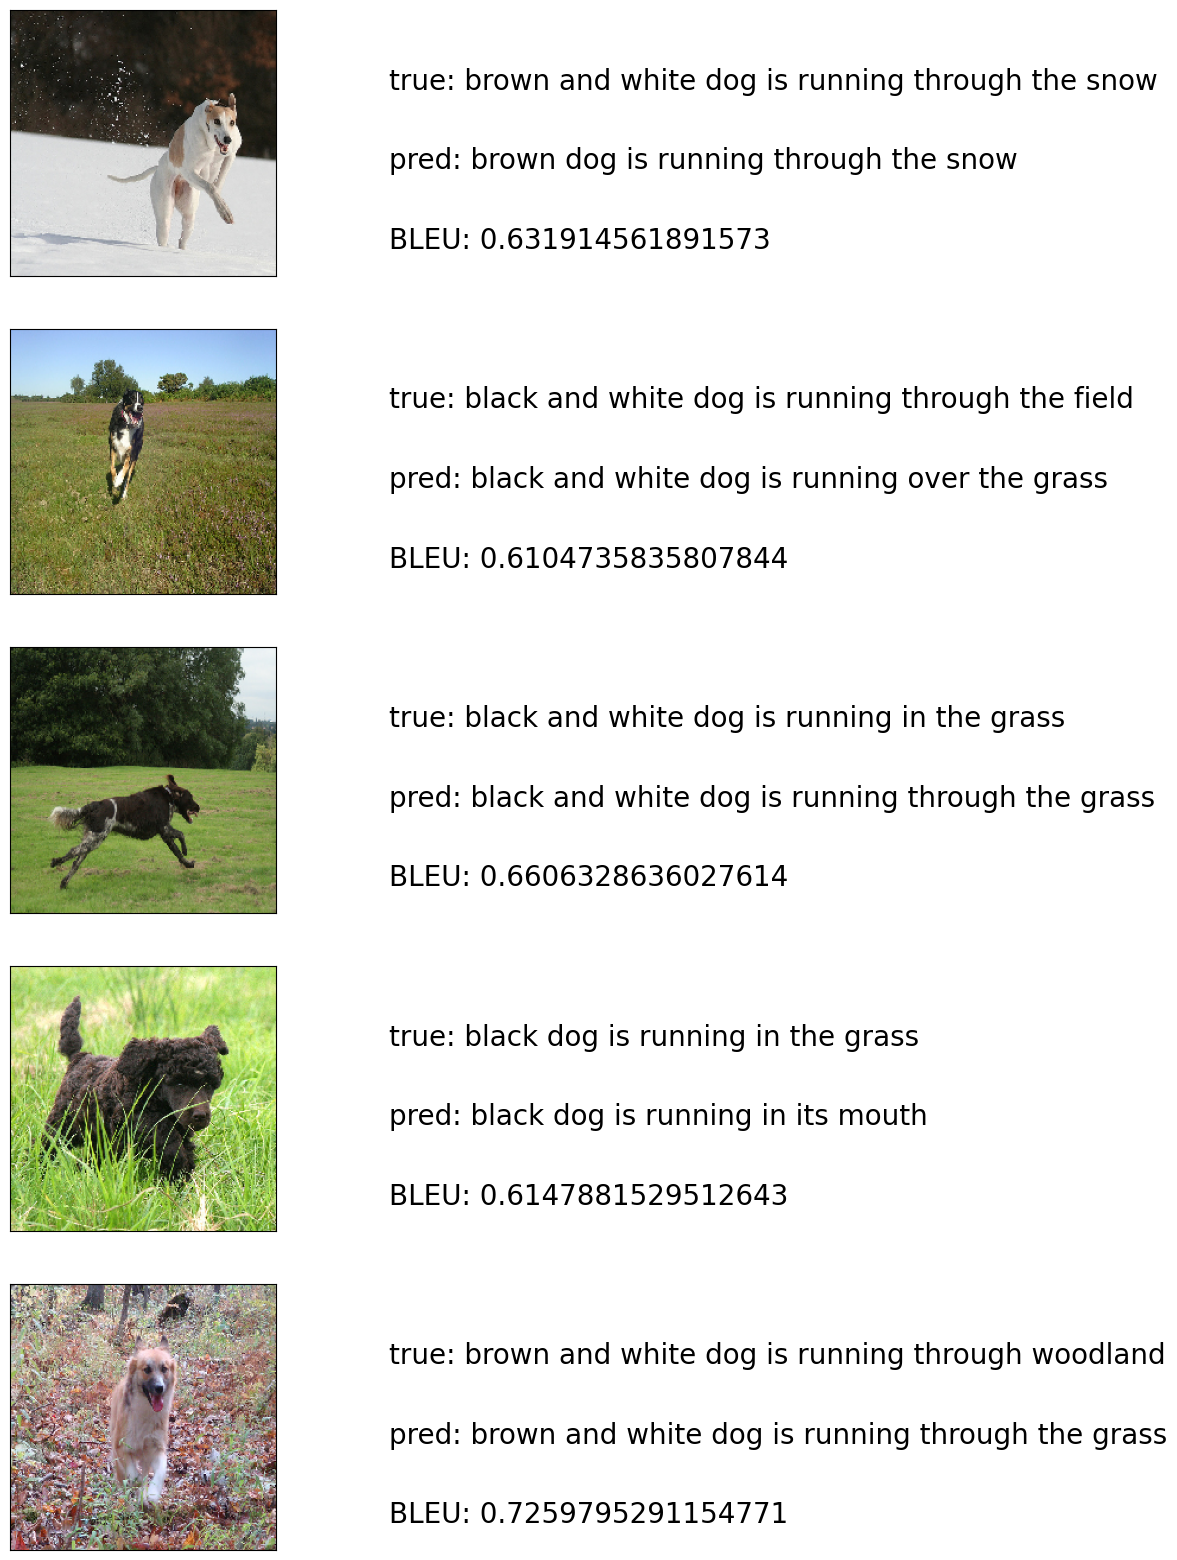

In [39]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)

In [40]:
model.save('image_caption_generator.h5')

In [41]:
#GUI
import tkinter as tk
from PIL import Image, ImageTk
from tkinter import filedialog

In [42]:
from keras.models import load_model
model = load_model('image_caption_generator.h5') # Path to your model

In [43]:
def upload_img():
    global img, image_data
    for img_display in frame.winfo_children():
        img_display.destroy()

    image_data = filedialog.askopenfilename(initialdir="/", title="Choose an image",
                                       filetypes=(("all files", "*.*"), ("png files", "*.png")))
    basewidth = 300
    img = Image.open(image_data)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    file_name = image_data.split('/')
    panel = tk.Label(frame, text= str(file_name[len(file_name)-1]).upper()).pack()
    panel_image = tk.Label(frame, image=img).pack()
    
def caption():
    
    original = Image.open(image_data)
    original = original.resize((224, 224), Image.ANTIALIAS)
    numpy_image = img_to_array(original)
    nimage = preprocess_input(numpy_image)
    
    feature = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    caption = predict_caption(feature)
    table = tk.Label(frame, text="Caption: " + caption[9:-7], font=("Helvetica", 12)).pack()

In [45]:
root = tk.Tk()
root.title('IMAGE CAPTION GENERATOR')
root.iconbitmap(r"C:\Users\aditi\image caption generator")
root.resizable(False, False)
tit = tk.Label(root, text="IMAGE CAPTION GENERATOR", padx=25, pady=6, font=("", 12)).pack()
canvas = tk.Canvas(root, height=550, width=600, bg='#D1EDf2')
canvas.pack()
frame = tk.Frame(root, bg='white')
frame.place(relwidth=0.8, relheight=0.8, relx=0.1, rely=0.1)
chose_image = tk.Button(root, text='Choose Image',
                        padx=35, pady=10,
                        fg="black", bg="pink", command=upload_img, activebackground="#add8e6")
chose_image.pack(side=tk.LEFT)

caption_image = tk.Button(root, text='Classify Image',
                        padx=35, pady=10,
                        fg="black", bg="pink", command=caption, activebackground="#add8e6")
caption_image.pack(side=tk.RIGHT)
root.mainloop()

1/1 [==============================] - 0s 188ms/step
